In [1]:
import etl_eda
import importlib
importlib.reload(etl_eda)
from etl_eda import *
import re
import opendatasets as od
from itertools import product
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

Data Extraction

In [2]:
data = 'https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data'
od.download(data)
dir = './competitive-data-science-predict-future-sales'
df_s = exctract(dir)

Skipping, found downloaded files in ".\competitive-data-science-predict-future-sales" (use force=True to force download)


In [3]:
for df in df_s:
    print(df.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00

Validity: Outliers detection

In [4]:
df_s[2].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Outliers in item_price

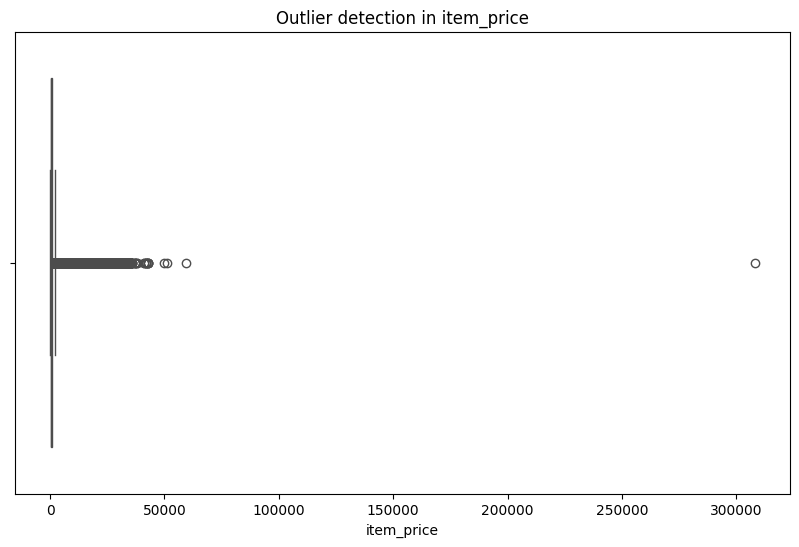

In [5]:
visual_outlierdetection(df_s[2], 'item_price')

In [6]:
df_s[2].loc[df_s[2].item_price > 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [7]:
df_s[2].loc[df_s[2].item_id == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [8]:
df_s[0].loc[df_s[0].item_id == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [9]:
df_s[1].loc[df_s[1].item_category_id == 75]

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


In [10]:
df_s[5].loc[df_s[5].item_id == 6066]

,ID,shop_id,item_id


We do not have this outlier in train set, and there is only one example of this outlier in train set - we could painless drop it

In [11]:
df_s[2] = df_s[2].loc[df_s[2].item_id != 6066]

Outliers in item_cnt_day

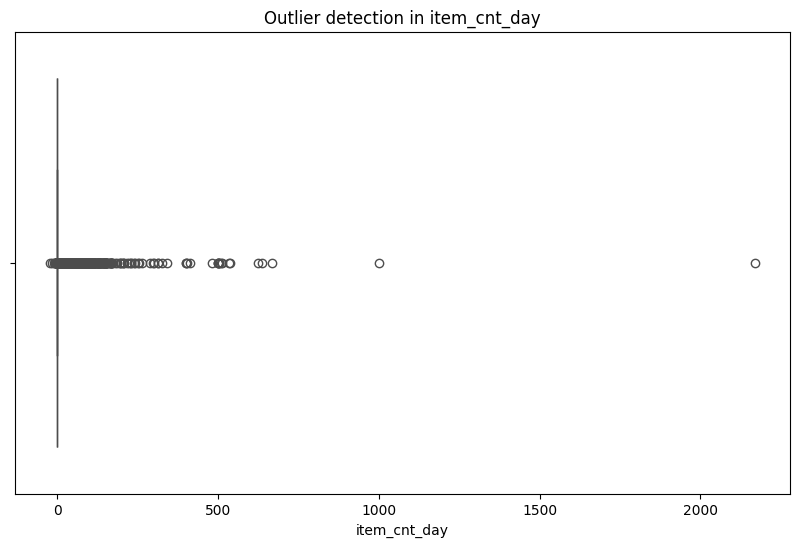

In [12]:
visual_outlierdetection(df_s[2], 'item_cnt_day')

In [13]:
df_s[2].loc[df_s[2].item_cnt_day >= 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


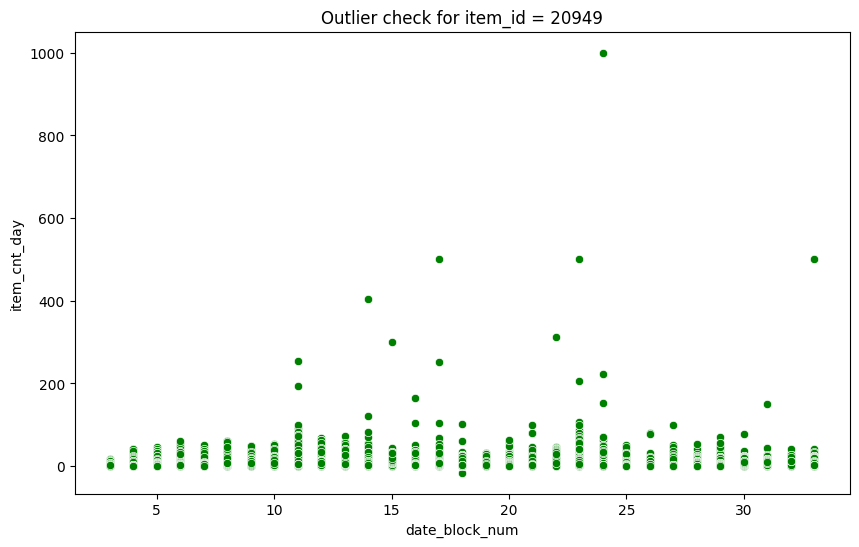

In [14]:
add_outlier_check(df_s[2], 'item_id', 20949, 'date_block_num', 'item_cnt_day')

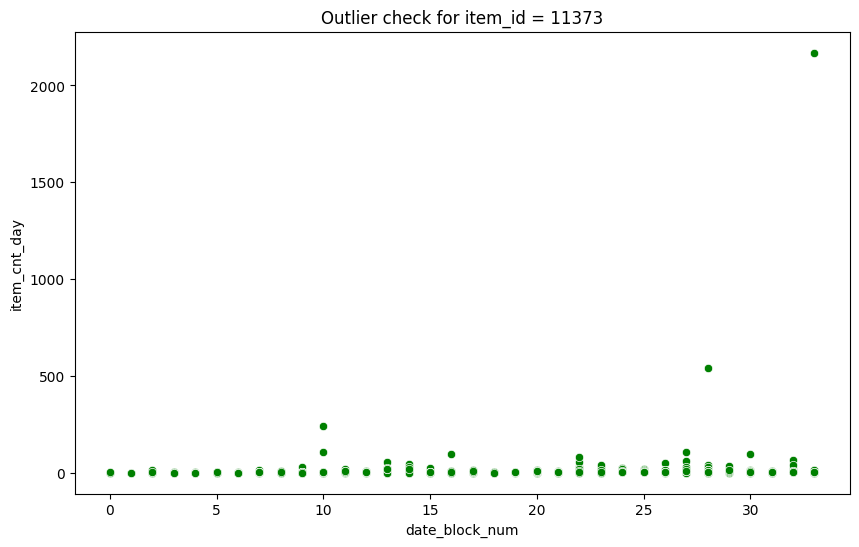

In [15]:
add_outlier_check(df_s[2], 'item_id', 11373, 'date_block_num', 'item_cnt_day')

We do not have tendencies that will approve preservation of this outliers - we can drop them

In [16]:
df_s[2] = df_s[2].loc[df_s[2].item_cnt_day < 1000]

Consistency: shop_name correction

In [17]:
pattern1 = "^!"
pattern2 = ""
for name in df_s[4]['shop_name'].unique():
    df_s[4].replace({'shop_name': {name: re.sub(pattern1, pattern2, name)}}, inplace = True)

In [18]:
df_s[4]['shop_name'].unique()

array(['Якутск Орджоникидзе, 56 фран', 'Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва ТЦ 

Completeness and Uniqueness check: NAN values and duplicates

In [19]:
duplicates_na(df_s)

               date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013               0       54    20130       149.0   
1435367  23.02.2014              13       50     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   
1866340  12.07.2014              18       25     3423       999.0   
2198566  31.12.2014              23       42    21619       499.0   

         item_cnt_day  
76962             1.0  
1435367           1.0  
1496766           1.0  
1671873           1.0  
1866340           1.0  
2198566           1.0  

Percentage of duplicates in df_s[2]: 0.0002%
Duplicates successfully dropped


In [20]:
df_items = df_s[0]
df_item_categories = df_s[1]
df_sales_train = df_s[2]
df_sample_submission = df_s[3]
df_shops = df_s[4]
df_test = df_s[5]

Itegrity data by int_snt_month

In [21]:
df_sales_per_month = df_sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg({'item_cnt_day':'sum', 'item_price': 'mean'})
df_sales_per_month = df_sales_per_month.rename({"item_cnt_day":"item_cnt_month"}, axis=1)
df_sales_per_month.reset_index(inplace = True)

In [22]:
df_sales_per_month.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


In [23]:
df_sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935846e+06,2.935846e+06,2.935846e+06,2.935846e+06,2.935846e+06
mean,1.456990e+01,3.300175e+01,1.019722e+04,8.907492e+02,1.241562e+00
std,9.422985e+00,1.622697e+01,6.324297e+03,1.720491e+03,2.217636e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,6.690000e+02


In [24]:
df_sales_per_month.describe()

,date_block_num,shop_id,item_id,item_cnt_month,item_price
count,1.609122e+06,1.609122e+06,1.609122e+06,1.609122e+06,1.609122e+06
mean,1.466479e+01,3.280587e+01,1.068099e+04,2.265233e+00,7.906943e+02
std,9.542325e+00,1.653700e+01,6.238881e+03,8.429583e+00,1.532592e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,9.000000e-02
25%,6.000000e+00,2.100000e+01,5.045000e+03,1.000000e+00,1.990000e+02
50%,1.400000e+01,3.100000e+01,1.049700e+04,1.000000e+00,3.990000e+02
75%,2.300000e+01,4.700000e+01,1.606000e+04,2.000000e+00,8.985000e+02
max,3.300000e+01,5.900000e+01,2.216900e+04,1.644000e+03,5.099900e+04


Uniqueness: Check similar named shops

In [25]:
for id in df_sales_per_month['shop_id'].unique():
    if df_sales_per_month[df_sales_per_month['shop_id'] == id].reset_index(drop = True)['date_block_num'].nunique() != 34:
        print(df_shops.loc[df_shops.shop_id == id, 'shop_name'].min())

Якутск Орджоникидзе, 56 фран
Якутск ТЦ "Центральный" фран
Воронеж ТРЦ Сити-Парк "Град"
Жуковский ул. Чкалова 39м?
Казань ТЦ "Бехетле"
Москва ТК "Буденовский" (пав.А2)
Москва ТЦ "МЕГА Белая Дача II"
Москва ТЦ "Новый век" (Новокосино)
Москва ТЦ "Перловский"
Москва ТЦ "Серебряный Дом"
СПб ТК "Сенная"
Тюмень ТЦ "Зеленый Берег"
Химки ТЦ "Мега"
Вологда ТРЦ "Мармелад"
Якутск Орджоникидзе, 56
Якутск ТЦ "Центральный"
Цифровой склад 1С-Онлайн
Красноярск ТЦ "Взлетка Плаза"
Выездная Торговля
Тюмень ТРЦ "Кристалл"
РостовНаДону ТРК "Мегацентр Горизонт"
РостовНаДону ТРК "Мегацентр Горизонт" Островной
Томск ТРЦ "Изумрудный Город"
Н.Новгород ТРЦ "РИО"
Мытищи ТРК "XL-3"
Москва "Распродажа"
Жуковский ул. Чкалова 39м²
Новосибирск ТРЦ "Галерея Новосибирск"


pair 1.Якутск Орджоникидзе, 56 фран and Якутск Орджоникидзе, 56

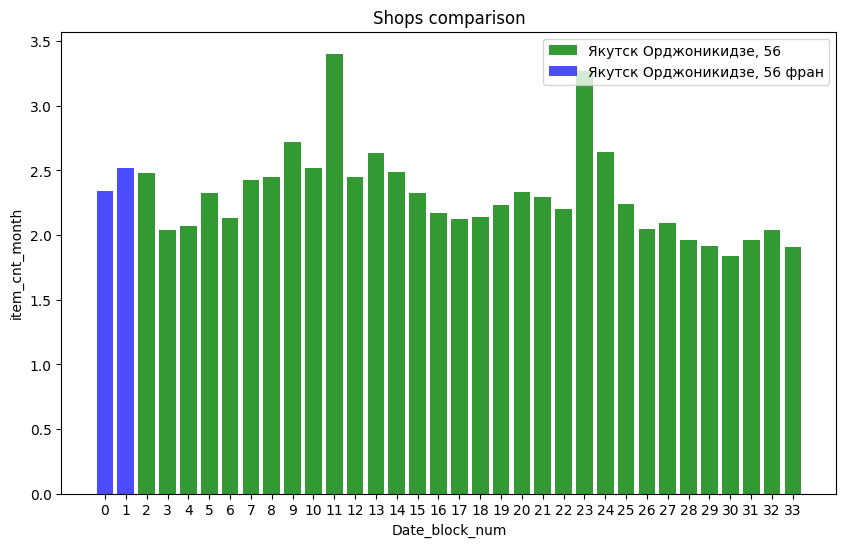

In [26]:
shop_name_check(df_shops, df_sales_per_month, 'Якутск Орджоникидзе, 56', 'Якутск Орджоникидзе, 56 фран')

Combining them - we'll get full range of data

In [27]:
shop_corr(df_shops, df_sales_per_month, 'Якутск Орджоникидзе, 56', 'Якутск Орджоникидзе, 56 фран')

Якутск ТЦ "Центральный" фран, Якутск ТЦ "Центральный"

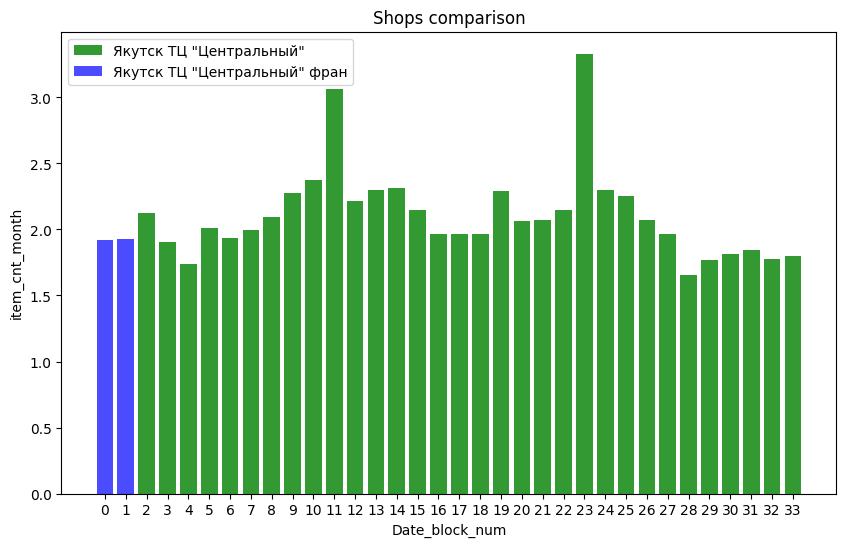

In [28]:
shop_name_check(df_shops, df_sales_per_month,'Якутск ТЦ "Центральный"', 'Якутск ТЦ "Центральный" фран')

In [29]:
shop_corr(df_shops, df_sales_per_month,'Якутск ТЦ "Центральный"', 'Якутск ТЦ "Центральный" фран')

Жуковский ул. Чкалова 39м?, Жуковский ул. Чкалова 39м²

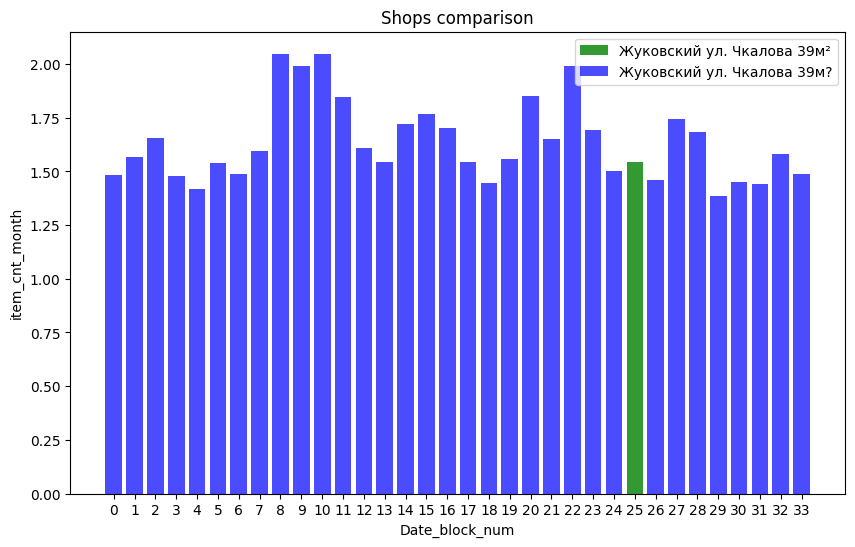

In [30]:
shop_name_check(df_shops, df_sales_per_month,'Жуковский ул. Чкалова 39м²', 'Жуковский ул. Чкалова 39м?')

In [31]:
shop_corr(df_shops, df_sales_per_month,'Жуковский ул. Чкалова 39м²', 'Жуковский ул. Чкалова 39м?')

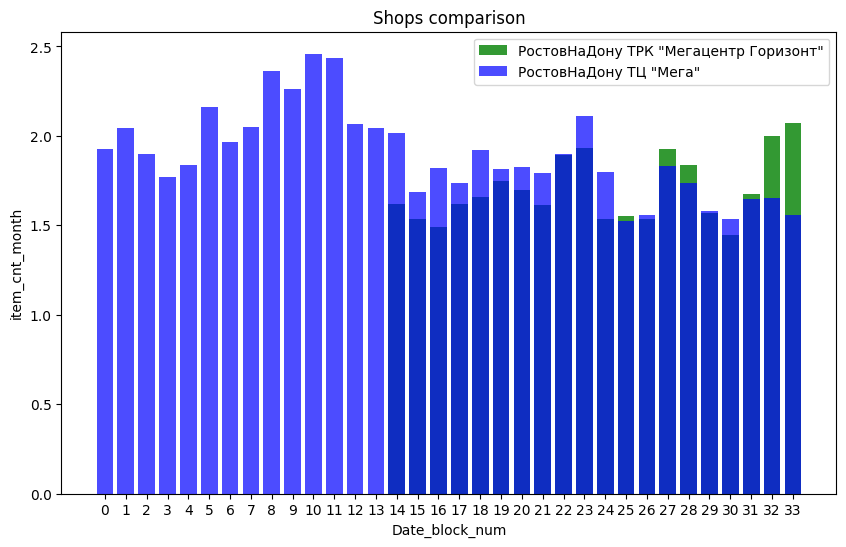

In [32]:
shop_name_1 = 'РостовНаДону ТРК "Мегацентр Горизонт"'
shop_name_2 = 'РостовНаДону ТЦ "Мега"'
shop_name_check(df_shops, df_sales_per_month,shop_name_1, shop_name_2)


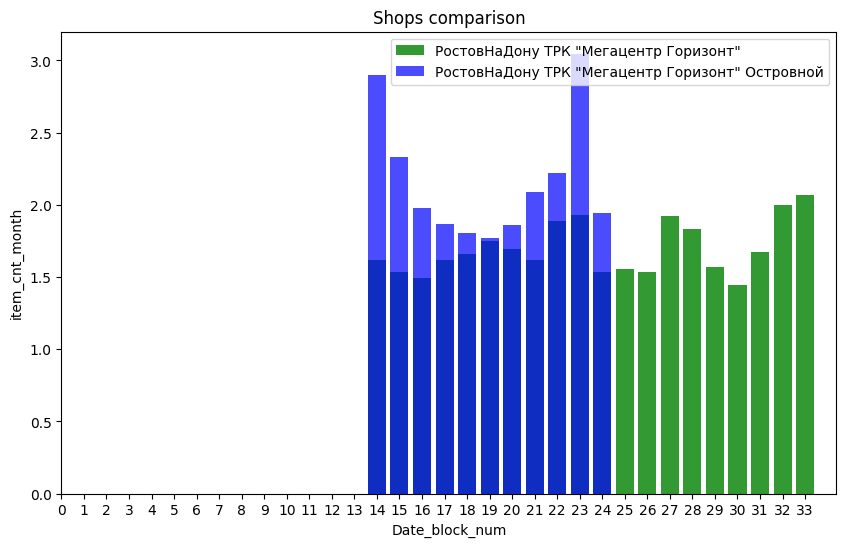

In [33]:
shop_name_1 = 'РостовНаДону ТРК "Мегацентр Горизонт"'
shop_name_2 = 'РостовНаДону ТРК "Мегацентр Горизонт" Островной'
shop_name_check(df_shops, df_sales_per_month,shop_name_1, shop_name_2)


So, as we do not get the full group - we will not combine them

Completeness: counting data that are not present training set that we need to predict

In [34]:
completeness_check(df_test, df_sales_per_month, 'item_id')

'The total amount of missing data:363'

counting data that have uncomplete time series range

In [35]:
completeness_check(df_sales_per_month, df_sales_per_month, 'shop_id')

'The total amount of missing data:0'

Completeness: Get the full data for full time series range and fill NAN with 0

In [36]:
full_data = []

for i in range(34):
    
    full_data.append(np.array(list(product([i], df_sales_per_month.shop_id.unique(), df_sales_per_month.item_id.unique()))))
columns = ['date_block_num','shop_id','item_id']
df_train = pd.DataFrame(np.vstack(full_data), columns=columns)
df_train.sort_values(by = columns, inplace = True)
df_train.head()


,date_block_num,shop_id,item_id
61086,0,2,0
59702,0,2,1
60779,0,2,2
60523,0,2,3
61087,0,2,4


In [37]:
df_sales_per_month.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,57,32,6.0,221.0
1,0,57,33,3.0,347.0
2,0,57,35,1.0,247.0
3,0,57,43,1.0,221.0
4,0,57,51,2.0,128.5


In [38]:
df_train = df_train.merge(df_sales_per_month, on = columns, how = 'left')
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,2,0,NaN,NaN
1,0,2,1,NaN,NaN
2,0,2,2,NaN,NaN
3,0,2,3,NaN,NaN
4,0,2,4,NaN,NaN


In [39]:
df_train.isna().sum()

date_block_num           0
shop_id                  0
item_id                  0
item_cnt_month    40650906
item_price        40650906
dtype: int64

In [40]:
df_train[['item_cnt_month', 'item_price']] = df_train[['item_cnt_month', 'item_price']].fillna(0)

Completeness and Adding data from test set that not in our train set

In [41]:
df_test['date_block_num'] = 34
df_train = pd.concat([df_train, df_test], ignore_index=True, sort=False, keys=columns)
df_train.isna().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_122748\2057749223.py:2: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  df_train = pd.concat([df_train, df_test], ignore_index=True, sort=False, keys=columns)


date_block_num           0
shop_id                  0
item_id                  0
item_cnt_month      214200
item_price          214200
ID                42260028
dtype: int64

In [42]:
df_train.drop('ID', axis = 1, inplace = True)
df_train = df_train.fillna(0)

ETL - load

In [43]:
to_csv(df_train, 'train.csv')
to_csv(df_item_categories, 'item_categories.csv')
to_csv(df_shops, 'shops.csv')
to_csv(df_items, 'items.csv')